g2 code

In [73]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils
import xray_vision
import xray_vision.mpl_plotting as mpl_plot
import time

from databroker import DataBroker as db, get_table
from csxtools.utils import get_fastccd_images, get_images_to_3D, get_images_to_4D, fccd_mask, get_fastccd_flatfield
from csxtools.image import stackmean, images_mean, images_sum
from csxtools.ipynb import image_stack_to_movie, show_image_stack
from matplotlib.colors import LogNorm
from skbeam.core import recip
from skbeam.core. utils import grid3d
from scipy.signal import savgol_filter as sgf
from matplotlib import colors
from ipywidgets import interact


## 1st Cycle


#640 ev 80 K (2019-10-17 17:53)  
light = db[122935]
dark0 = db[122936]
dark1 = db[122937]
dark2 = db[122938]


#630 ev 80 K (2019-10-17 20:14)
light = db[122951]
dark0 = db[122952]
dark1 = db[122953]
dark2 = db[122954]

#640 ev 65 K (2019-10-17 20:14)
light = db[122951]
dark0 = db[122952]
dark1 = db[122953]
dark2 = db[122954]

#640 ev 55 K (2019-10-17 20:14)
light = db[122951]
dark0 = db[122952]
dark1 = db[122953]
dark2 = db[122954]

#630 ev 55 K (2019-10-17 20:14)
light = db[122951]
dark0 = db[122952]
dark1 = db[122953]
dark2 = db[122954]


#640 ev 50 K (2019-10-17 20:14)
light = db[122951]
dark0 = db[122952]
dark1 = db[122953]
dark2 = db[122954]


#640 ev 40 K (2019-10-17 20:14)
light = db[122951]
dark0 = db[122952]
dark1 = db[122953]
dark2 = db[122954]




In [74]:
#on resonance
light_1 = db[123146]
dark0_1 = db[123143]
dark1_1 = db[123144]
dark2_1 = db[123145]


#off resonance
light_2 = db[123150]
dark0_2 = db[123147]
dark1_2 = db[123148]
dark2_2 = db[123149]



images1 = get_fastccd_images(light_1, (dark0_1, dark1_1, dark2_1), flat=None)
stack1 = get_images_to_3D(images1)

images2 = get_fastccd_images(light_2, (dark0_2, dark1_2, dark2_2), flat=None)
stack2 = get_images_to_3D(images2)

mean_stack1 = stackmean(stack1)
mean_stack2= stackmean(stack2)


/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/csxtools/utils.py:181: UserWarning: Images and get_images are deprecated. Use Header.data('fccd_image') instead.
  images = header.db.get_images(header, tag)


In [75]:
csx_tbl1 = light_1.table(fill =False,stream_name='baseline')
csx_tbl2 = light_2.table(fill =False,stream_name='baseline')

In [107]:
df1=pd.DataFrame(csx_tbl1)
df2=pd.DataFrame(csx_tbl2)

In [108]:
#displaying shape
df1.shape

(2, 200)

In [109]:
#looking for the temp and energy set point for particular column in light table
print(df1['stemp_temp_A_T'])
print(df1['pgm_energy_setpoint'])

print(df2['stemp_temp_A_T'])
print(df2['pgm_energy_setpoint'])

seq_num
1    79.9958
2    79.9955
Name: stemp_temp_A_T, dtype: float64
seq_num
1    642.0
2    642.0
Name: pgm_energy_setpoint, dtype: float64
seq_num
1    80.0024
2    80.0000
Name: stemp_temp_A_T, dtype: float64
seq_num
1    645.0
2    645.0
Name: pgm_energy_setpoint, dtype: float64


Organing data for plooting and looking for speckels patterns






In [110]:
#displaying shape of stack(3D)
print(stack1.shape)
print(stack2.shape)

(3600, 960, 1000)
(3400, 960, 1000)


In [111]:
#displaying shape of mean stack(2D)
print(mean_stack1.shape)
print(mean_stack2.shape)

(960, 1000)
(960, 1000)


/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


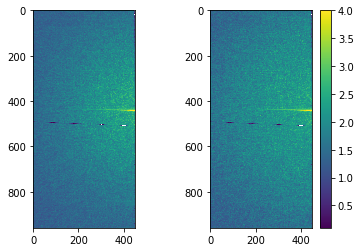

In [112]:
#plotting using matplotlib
%matplotlib inline
fig, ax = plt.subplots(1,2)
csx_im1 =ax[0].imshow(np.log10(mean_stack1[0:960,550:1000]),vmin=0.1,vmax=4)
csx_im2 =ax[1].imshow(np.log10(mean_stack2[0:960,550:1000]),vmin=0.1,vmax=4)
plt.colorbar(csx_im1);



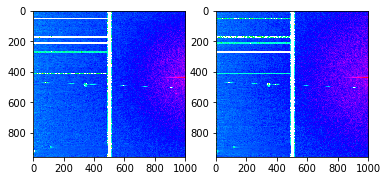

In [113]:
#looking for speckle patterns
% matplotlib inline
fig, ax = plt.subplots(1,2)
csx_ima1=ax[0].imshow(mean_stack1, cmap='hsv', interpolation=None, norm=LogNorm())
csx_ima1=ax[1].imshow(mean_stack2, cmap='hsv', interpolation=None, norm=LogNorm())

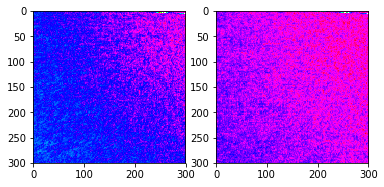

In [114]:
#looking for speckle patterns on specific area
% matplotlib inline
fig, ax = plt.subplots(1,2)
csx_imag1=ax[0].imshow(mean_stack1[500:800,600:900], cmap='hsv', interpolation=None, norm=LogNorm())
csx_imag2=ax[1].imshow(mean_stack2[500:800,600:900], cmap='hsv', interpolation=None, norm=LogNorm())

In [115]:
#function for ROI definition

def show_label_array_on_image(ax, images, label_array, set_aspect='auto', cmap=None, imshow_cmap='hsv', norm=LogNorm(), **kwargs):
    im = ax.imshow(images, cmap=imshow_cmap, interpolation=None, norm=norm, **kwargs)
    im_label = mpl_plot.show_label_array(ax, label_array, cmap=cmap, norm=norm, alpha=1, **kwargs)
    return im, im_label
    

In [116]:
#making a ring for specific q
roi_edge = (510,530)
#roi_edge = (120,130)
label_array1 = roi.rings(roi_edge, (450, 1050), shape=mean_stack1.shape)
label_array2 = roi.rings(roi_edge, (450, 1050), shape=mean_stack2.shape)

(<matplotlib.image.AxesImage at 0x7f7c3ac2dcf8>,
 <matplotlib.image.AxesImage at 0x7f7c3ac275f8>)

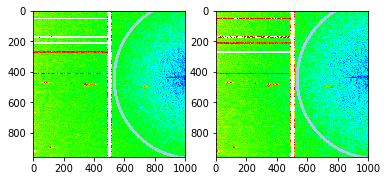

In [117]:
#plot_roi(images_sq, label_array)
% matplotlib inline
fig,ax = plt.subplots(1,2)
show_label_array_on_image(ax[0], mean_stack1, label_array1)
show_label_array_on_image(ax[1], mean_stack2, label_array2)


In [118]:
#seeting number of levels and buffres to calculate g2
#num_levels=how many generations of downsampling to perform(int)
#num_bufs=maximum lag step to compute in each generation of downsampling(int, must be even)
[num_levels, num_bufs] = [8, 14]


In [119]:
#skbeam.core.correlation.multi_tau_auto_corr(num_levels, num_bufs, labels, images)
#The longest lag time computed is num_levels * num_bufs.
#lag_steps: the times at which the correlation was computed
start_time = time.time()
label = label_array1

g2_1, lag_steps_1 = corr.multi_tau_auto_corr(num_levels, num_bufs, label, stack1)

g2_2, lag_steps_2 = corr.multi_tau_auto_corr(num_levels, num_bufs, label, stack2)
print("--- Time to calculate autocorrelation function: {} seconds ---".format(time.time() - start_time))

--- Time to calculate autocorrelation function: 53.18564820289612 seconds ---


In [120]:
print(lag_steps_1)
print(lag_steps_2)

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   16   18   20   22   24   26   28   32   36   40   44   48   52
   56   64   72   80   88   96  104  112  128  144  160  176  192  208
  224  256  288  320  352  384  416  448  512  576  640  704  768  832
  896 1024 1152 1280 1408 1536 1664]
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   16   18   20   22   24   26   28   32   36   40   44   48   52
   56   64   72   80   88   96  104  112  128  144  160  176  192  208
  224  256  288  320  352  384  416  448  512  576  640  704  768  832
  896 1024 1152 1280 1408 1536 1664]


In [121]:
# looking for g2
print(g2_1[:])
print(g2_2[:])

[[2.0970056 ]
 [1.10099176]
 [1.09713888]
 [1.09525862]
 [1.09695039]
 [1.09896448]
 [1.09995449]
 [1.09868325]
 [1.09748638]
 [1.09595043]
 [1.09796681]
 [1.09770966]
 [1.0988188 ]
 [1.09833188]
 [1.09799409]
 [1.09772844]
 [1.09808694]
 [1.09746016]
 [1.09748654]
 [1.09780905]
 [1.09757433]
 [1.097768  ]
 [1.09760619]
 [1.09754301]
 [1.09740747]
 [1.09745874]
 [1.09757841]
 [1.09737452]
 [1.09746403]
 [1.09727846]
 [1.09723492]
 [1.09716101]
 [1.09712149]
 [1.09703294]
 [1.09688419]
 [1.09686585]
 [1.0967739 ]
 [1.09672956]
 [1.09668232]
 [1.09664046]
 [1.09667188]
 [1.09667948]
 [1.09667134]
 [1.09673475]
 [1.09676233]
 [1.09684561]
 [1.096967  ]
 [1.09703604]
 [1.09693657]
 [1.09692332]
 [1.09679396]
 [1.09669782]
 [1.0967078 ]
 [1.0968132 ]
 [1.09687646]
 [1.0966817 ]
 [1.09665901]
 [1.09666483]
 [1.09672052]
 [1.09644646]
 [1.09681941]
 [1.09670292]
 [1.09641909]]
[[1.87812025]
 [1.18048834]
 [1.17911881]
 [1.17798161]
 [1.17882793]
 [1.17944972]
 [1.17984661]
 [1.17933501]
 [1.1

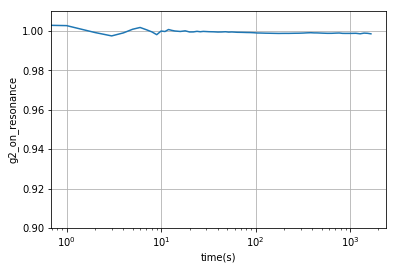

In [122]:
#tbl.fccd_acquire_time.values[0]and g2_t/g2_t[10]
% matplotlib inline
ax=plt.semilogx(lag_steps_1 * 1 ,g2_1/g2_1[10]) 
plt.ylabel('g2_on_resonance')
plt.xlabel('time(s)')
plt.ylim(0.9, 1.0104);
plt.grid()

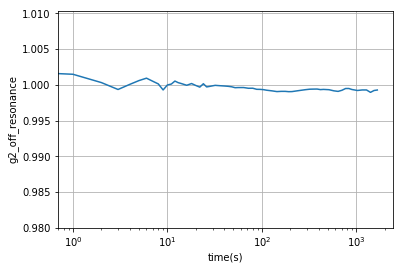

In [124]:
#tbl.fccd_acquire_time.values[0]and g2_t/g2_t[10]
% matplotlib inline
ax=plt.semilogx(lag_steps_2 * 1 ,g2_2/g2_2[10]) 
plt.ylabel('g2_off_resonance')
plt.xlabel('time(s)')
plt.ylim(0.98, 1.0104);
plt.grid()

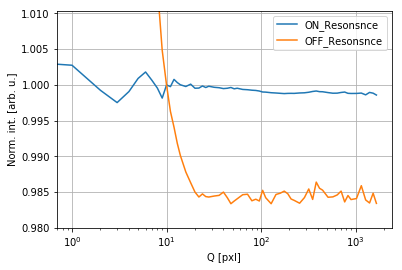

In [105]:

fig, ax= plt.subplots()
ax.semilogx(lag_steps_1 * 1 ,g2_1/g2_1[10], label="ON_Resonsnce")
ax.semilogx(lag_steps_2 * 1 ,g2_2/g2_2[10],label="OFF_Resonsnce" ) 
ax.legend()
ax.grid()
ax.set_ylim(0.98, 1.0104);
ax.set_xlabel('Q [pxl]');
ax.set_ylabel('Norm. int. [arb. u.]');